In [1]:
# Packages

import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import wasserstein_distance
from tqdm import trange

In [2]:
# Utils

def draw(proba_dist):
    rand_num = np.random.uniform(0, 1)
    cum_prob = np.cumsum(proba_dist)
    for idx, _ in enumerate(proba_dist):
        if cum_prob[idx] >= rand_num:
            selected_idx = idx
            break
    return selected_idx

def render_policy(policy):
    plt.imshow(policy.reshape(-1,1).T, extent=[0, policy.shape[0], 0, 1], vmin=0, vmax=1.)
    plt.grid(True, which='both', color='w', linewidth=1)
    plt.xticks(np.arange(policy.shape[0]))
    plt.yticks([])
    plt.show()

def Hellinger_dist(P, Q):
    assert P.shape[0]==Q.shape[0]
    return 1 / np.sqrt(2) * np.sqrt((np.square(np.sqrt(P) - np.sqrt(Q))).sum())

def swap(vect_init, vect_ref, idx_seen, i, j):
    vect = vect_init.copy()
    if not idx_seen[i] and not idx_seen[j]:
        vect[i], vect[j] = vect_ref[j], vect_ref[i]
    elif not idx_seen[i]:
        vect[i] = vect_ref[j]
    elif not idx_seen[j]:
        vect[j] = vect_ref[i]
    return vect

def learner_generalization(policy_1, demonstration_2):
    idx_sorted_mass = np.argsort(policy_1)
    idx_seen = np.zeros_like(policy_1)
    count_music_button = 1
    policy_2 = policy_1
    for a, r in zip(demonstration_2[0], demonstration_2[1]):
        if r == 0:
            policy_2[a] = 0
        elif r == 1:
            a_prime = idx_sorted_mass[-count_music_button]
            # Swap with most probable
            policy_2 = swap(policy_2, policy_1, idx_seen, a, a_prime)
            count_music_button += 1
        else: 
            raise ValueError('Unknown value of the reward')
        idx_seen[a] = True
    policy_2 = policy_2 / np.sum(policy_2)
    return policy_2

def cost(demonstration, alpha=0.02):
    return  - len(demonstration[0]) * alpha


In [3]:
class ButtonsToy:
    # States
    n_buttons = None
    # Reward function 
    n_music = None
    R = None

    def __init__(self, nb, n_music, music_idx=None):
        self.n_buttons =  nb
        self.n_music = n_music
        self.R = np.zeros(self.n_buttons)
        if music_idx is None:
            music_idx = random.sample(list(np.arange(0, self.n_buttons)), self.n_music)
        else:
            assert len(np.unique(music_idx)) == self.n_music
        self.R[music_idx] = np.ones_like(music_idx)

    def render(self):
        plt.imshow(self.R.reshape(-1,1).T, extent=[0, self.n_buttons, 0, 1])
        plt.grid(True, which='both', color='w', linewidth=1)
        plt.xticks(np.arange(self.n_buttons))
        plt.yticks([])
    
    def eval(self, a):
        assert a >= 0 and a < self.R.shape[0]
        return self.R[a]
        

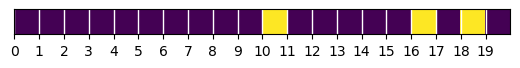

In [4]:
env = ButtonsToy(20, 3)
env.render()

#### Teacher

In [5]:
class Teacher:
    policy = None
    env = None

    def __init__(self, env):
        self.env = env
        # Master the toy
        self.policy = env.R / env.R.sum()
    
    def act(self, size=1):
        actions = []
        rewards = []
        for _ in range(size):
            a = draw(self.policy)
            actions.append(a)
            rewards.append(self.env.eval(a))
        return actions, rewards

    def demonstrate(self):
        pass

    def change_env(self, env):
        self.__init__(env)

class NaiveTeacher(Teacher):
    def __init__(self, env):
        super().__init__(env)
        
    def demonstrate(self, size=1):
        return self.act(size=size)
        

#### Learner

In [6]:
class Learner():
    policy = None
    env = None
    is_knowledgeable = None

    def __init__(self, env, knowledgeable=True):
        self.env = env
        self.is_knowledgeable = knowledgeable
        if knowledgeable:
            self.policy = env.R / env.R.sum()
        else:
            self.policy = np.ones(env.R.shape[0]) / env.R.shape[0]

    def act(self, size=1):
        actions = []
        rewards = []
        for _ in range(size):
            a = draw(self.policy)
            actions.append(a)
            rewards.append(self.env.eval(a))
        return actions, rewards

    def generalization(self, demonstration):
        return learner_generalization(self.policy, demonstration)

### Phase 1 - Teacher estimates if the Learner know the toy or not

#### Estimate of the learner policy

In [7]:
class ToMTeacher(Teacher):
    # Learner representation
    learner_estimate_policy = None
    learning_env = None
    distance = lambda x,y : None
    knowledgeable_policy = None
    knowledgeable_demo = None
    dumb_policy = None
    dumb_demo = None

    def __init__(self, learning_env, env, distance=wasserstein_distance):
        super().__init__(env)
        # Suppose dumb learners
        self.learner_estimate_policy = np.ones_like(self.policy) / self.policy.shape[0]
        self.learning_env = learning_env
        self.env = env
        self.distance = distance
        # Init policy
        self.knowledgeable_policy = self.learning_env.R / self.learning_env.R.sum()
        self.dumb_policy = np.ones(self.learning_env.n_buttons) / self.learning_env.n_buttons
        
        # Init demonstrations
        actions, rewards = [], []
        # Knowledgeable learner
        for idx in np.where(self.env.R==1)[0]:
            actions.append(idx)
            rewards.append(self.env.eval(idx))
        self.knowledgeable_demo = (actions, rewards)
        
        actions, rewards = [], []
        # Dumb learner
        for idx in range(self.env.n_buttons):
            actions.append(idx)
            rewards.append(self.env.eval(idx))
        self.dumb_demo = (actions, rewards)

    def observe(self, trajectory, d_mass):
        # Update learner model
        # d_mass updating parameter
        actions, _ = trajectory
        for action in actions:
            self.learner_estimate_policy[action] += d_mass
            self.learner_estimate_policy /= self.learner_estimate_policy.sum()
        
    def demonstrate_distance(self):
        # Closest policy
        dist_knowledgeable = self.distance(self.knowledgeable_policy, self.learner_estimate_policy)
        dist_dumb = self.distance(self.dumb_policy, self.learner_estimate_policy)

        if dist_knowledgeable < dist_dumb:
            # Knowledgeable learner
            demo = self.knowledgeable_demo
            is_knowledgeable = True
        else:
            # Dumb learner
            demo = self.dumb_demo
            is_knowledgeable = False
        return demo[0], demo[1], is_knowledgeable
    
    def demonstrate_referent(self, eps, referent):
        # Threshold on the distance to a referent policy
        if referent == 'knowledgeable':
            prior = True
            ref_policy = self.knowledgeable_policy
            ref_demo = self.knowledgeable_demo
            alter_demo = self.dumb_demo
        elif referent == 'dumb':
            prior = False
            ref_policy = self.dumb_policy
            ref_demo = self.dumb_demo
            alter_demo = self.knowledgeable_demo
        else: raise ValueError('Unknown prior')

        dist = self.distance(ref_policy, self.learner_estimate_policy)
        if dist < eps:
            return ref_demo[0], ref_demo[1], prior
        else:
            return alter_demo[0], alter_demo[1], not prior

    def demonstrate_utility(self, cost_funct=cost):
        # Utility 
        utilities = []
        demonstrations = [self.knowledgeable_demo, self.dumb_demo]
        is_knowledgeables = [True, False]

        # Estimate utility
        for dem in demonstrations:
            learner_policy_2 = learner_generalization(self.learner_estimate_policy, dem)
            estimate_reward = np.sum(learner_policy_2 * self.env.R)
            dem_cost = cost_funct(dem)
            utilities.append(estimate_reward + dem_cost)

        argmax_set = np.where(np.is_close(utilities, np.max(utilities)))[0]
        select_idx = np.random.choice(argmax_set)
        return demonstrations[select_idx][0], demonstrations[select_idx][1], is_knowledgeables[select_idx]


Learning environment


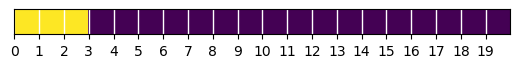

Evaluation environment


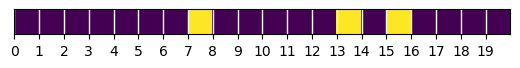

In [8]:
n = 20
m = 3

learning_env = ButtonsToy(n, m, music_idx=[0,1,2])
evaluation_env = ButtonsToy(n, m)

print('Learning environment')
learning_env.render()
plt.show()

print('Evaluation environment')
evaluation_env.render()

##### Distance to the learner policy - knowledgeable learner

In [9]:
# ToM teacher
tom_teacher = ToMTeacher(learning_env, evaluation_env)
# Knowledgeable learner
learner = Learner(learning_env, knowledgeable=True)

In [10]:
d_mass_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]
dict = {}

for d_mass in d_mass_values:
    distances_hell = []
    distances_was = []
    # Init teacher
    tom_teacher = ToMTeacher(learning_env, evaluation_env)

    for run in range(100):
        traj = learner.act()
        tom_teacher.observe(traj, d_mass=d_mass)
        #render_policy(tom_teacher.learner_estimate_policy)
        
        # Distances to perf policy
        perfect_policy = learning_env.R / learning_env.R.sum()
        dist_hell = Hellinger_dist(perfect_policy, tom_teacher.learner_estimate_policy)
        dist_was = wasserstein_distance(perfect_policy, tom_teacher.learner_estimate_policy)
        distances_hell.append(dist_hell)
        distances_was.append(dist_was)
        
    dict[d_mass] = {}
    dict[d_mass]['hellinger'] = distances_hell
    dict[d_mass]['wasserstein'] = distances_was

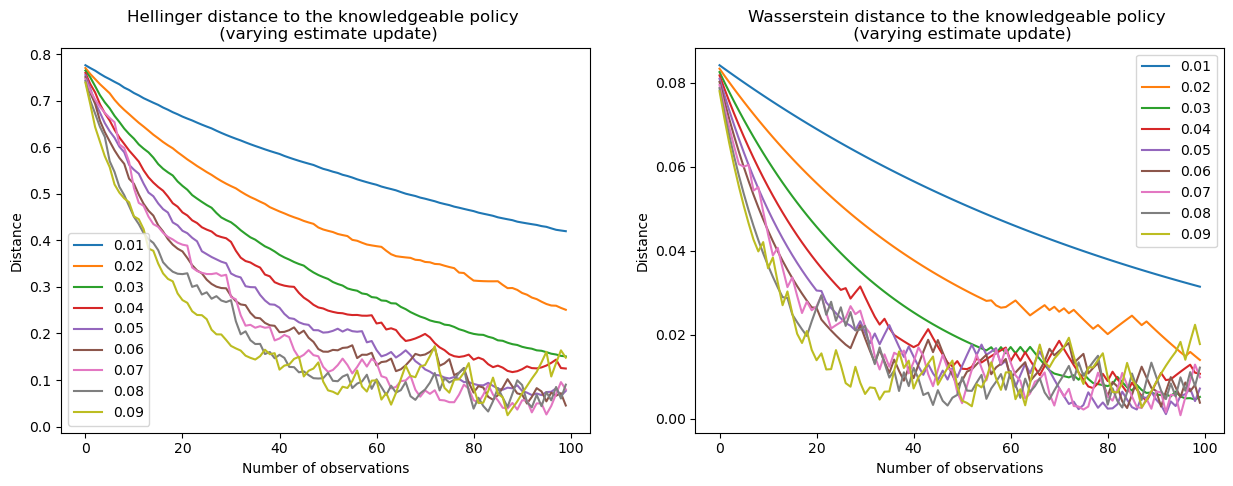

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
for d_mass in d_mass_values:
    distances_hell = dict[d_mass]['hellinger']
    distances_was = dict[d_mass]['wasserstein']

    ax1.plot(distances_hell, label=str(d_mass))
    ax1.set_xlabel("Number of observations")
    ax1.set_ylabel("Distance")
    ax1.set_title(f"Hellinger distance to the knowledgeable policy \n (varying estimate update)")
    ax1.legend()

    ax2.plot(distances_was, label=str(d_mass))
    ax2.set_xlabel("Number of observations")
    ax2.set_ylabel("Distance")
    ax2.set_title(f"Wasserstein distance to the knowledgeable policy \n (varying estimate update)")
    
ax1.legend()
ax2.legend();

In [45]:
print("Smallest distance")
_, _, is_knowledgeable = tom_teacher.demonstrate_distance()
print(f"Is the learner knowledgeable? \033[1m {is_knowledgeable} \033[0m \n")

print("Dumb until distance to knowledgeable policy smaller than eps")
_, _, is_knowledgeable = tom_teacher.demonstrate_referent(eps=0.02, referent='knowledgeable')
print(f"Is the learner knowledgeable? \033[1m {is_knowledgeable} \033[0m \n")

print("Knowledgeable until distance to dumb policy smaller than eps")
_, _, is_knowledgeable = tom_teacher.demonstrate_referent(eps=0.02, referent='dumb')
print(f"Is the learner knowledgeable? \033[1m {is_knowledgeable} \033[0m \n")

print("Utility")
_, _, is_knowledgeable = tom_teacher.demonstrate_utility()
print(f"Is the learner knowledgeable? \033[1m {is_knowledgeable} \033[0m \n")

Smallest distance
Is the learner knowledgeable?  True  

Dumb until distance to knowledgeable policy smaller than eps
Is the learner knowledgeable?  True  

Knowledgeable until distance to dumb policy smaller than eps
Is the learner knowledgeable?  True  

Utility
Is the learner knowledgeable?  True  



##### Distance to the learner policy - dumb learner

In [14]:
# ToM teacher 
tom_teacher = ToMTeacher(learning_env, evaluation_env)
# Dumb learner
learner = Learner(learning_env, knowledgeable=False)

In [15]:
d_mass_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]
dict = {}

for d_mass in d_mass_values:
    distances_hell = []
    distances_was = []
    # Init teacher
    tom_teacher = ToMTeacher(learning_env, evaluation_env)

    for run in range(1000):
        traj = learner.act()
        tom_teacher.observe(traj, d_mass=d_mass)
        #render_policy(tom_teacher.learner_estimate_policy)
        
        # Distances to perf policy
        dumb_policy = np.ones_like(learning_env.R) / learning_env.R.shape[0]
        dist_hell = Hellinger_dist(dumb_policy, tom_teacher.learner_estimate_policy)
        dist_was = wasserstein_distance(dumb_policy, tom_teacher.learner_estimate_policy)
        distances_hell.append(dist_hell)
        distances_was.append(dist_was)
        
    dict[d_mass] = {}
    dict[d_mass]['hellinger'] = distances_hell
    dict[d_mass]['wasserstein'] = distances_was

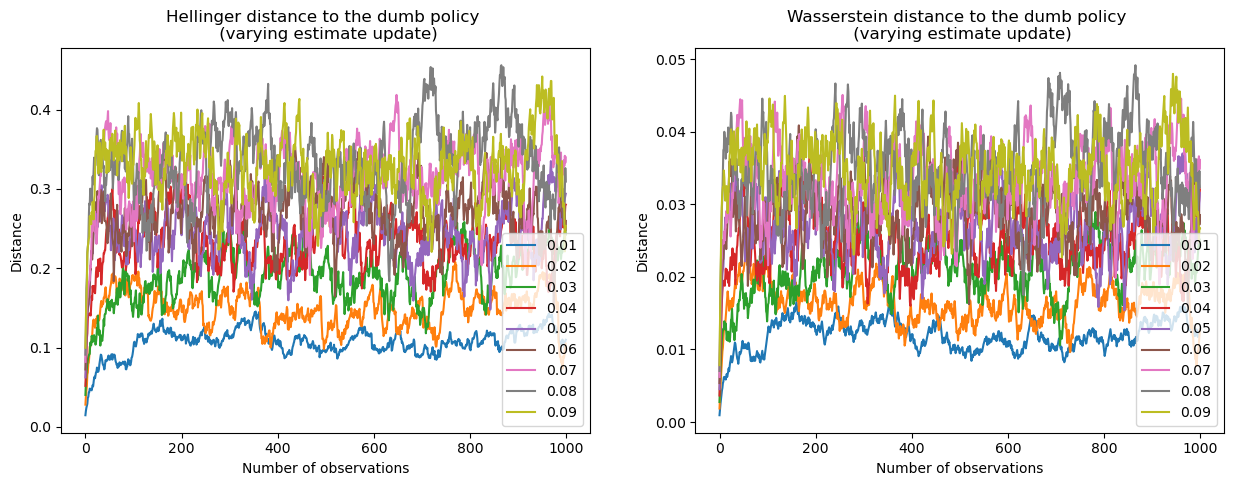

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
for d_mass in d_mass_values:
    distances_hell = dict[d_mass]['hellinger']
    distances_was = dict[d_mass]['wasserstein']

    ax1.plot(distances_hell, label=str(d_mass))
    ax1.set_xlabel("Number of observations")
    ax1.set_ylabel("Distance")
    ax1.set_title(f"Hellinger distance to the dumb policy \n (varying estimate update)")
    ax1.legend()

    ax2.plot(distances_was, label=str(d_mass))
    ax2.set_xlabel("Number of observations")
    ax2.set_ylabel("Distance")
    ax2.set_title(f"Wasserstein distance to the dumb policy \n (varying estimate update)")

ax1.legend()
ax2.legend();

In [49]:
print("Smallest distance")
_, _, is_knowledgeable = tom_teacher.demonstrate_distance()
print(f"Is the learner knowledgeable? \033[1m {is_knowledgeable} \033[0m \n")

print("Dumb until distance to knowledgeable policy smaller than eps")
_, _, is_knowledgeable = tom_teacher.demonstrate_referent(eps=0.02, referent='knowledgeable')
print(f"Is the learner knowledgeable? \033[1m {is_knowledgeable} \033[0m \n")

print("Knowledgeable until distance to dumb policy smaller than eps")
_, _, is_knowledgeable = tom_teacher.demonstrate_referent(eps=0.04, referent='dumb')
print(f"Is the learner knowledgeable? \033[1m {is_knowledgeable} \033[0m \n")

print("Utility")
_, _, is_knowledgeable = tom_teacher.demonstrate_utility()
print(f"Is the learner knowledgeable? \033[1m {is_knowledgeable} \033[0m \n")

Smallest distance
Is the learner knowledgeable?  False  

Dumb until distance to knowledgeable policy smaller than eps
Is the learner knowledgeable?  False  

Knowledgeable until distance to dumb policy smaller than eps
Is the learner knowledgeable?  False  

Utility
Is the learner knowledgeable?  False  



##### Experiments utils

In [74]:
def test_accuracy(d_mass_values, method, N=1000, num_obs=100, 
                  distance=wasserstein_distance, referent=None, eps=None, 
                  learner_type=None, cost_funct=cost):
    dict = {}
    distance = wasserstein_distance

    for d_mass in d_mass_values:
        all_evals = []
        for _ in trange(N):
            # Generate new env 
            learning_env = ButtonsToy(n, m)
            evaluation_env = ButtonsToy(n, m)
            tom_teacher = ToMTeacher(learning_env, evaluation_env, distance=distance)
            if learner_type == None:
                learner = Learner(learning_env, knowledgeable=(np.random.rand() < 0.5))
            elif learner_type == 'knowledgeable':
                learner = Learner(learning_env, knowledgeable=True)
            elif learner_type == 'dumb':
                learner = Learner(learning_env, knowledgeable=False)
            else:
                raise ValueError('Unknown learner type')
            evals = []
            for _ in range(num_obs):
                # Teacher evaluation
                if method == 'distance':
                    _, _, is_knowledgeable = tom_teacher.demonstrate_distance()
                elif method == 'threshold':
                    assert referent != None and eps != None
                    _, _, is_knowledgeable = tom_teacher.demonstrate_referent(eps=eps, referent=referent)
                elif method == 'utility':
                     _, _, is_knowledgeable = tom_teacher.demonstrate_utility(cost_funct=cost_funct)
                else:
                    raise ValueError('Unknown demonstration method')
                evals.append(is_knowledgeable == learner.is_knowledgeable)
                # Learner plays and teacher observes
                traj = learner.act()
                tom_teacher.observe(traj, d_mass=d_mass)
            all_evals.append(evals)
        dict[d_mass] = {}
        dict[d_mass]['all_evals'] = all_evals
    return dict

In [75]:
def display_accuracy(dictionnaries, sub_titles, d_mass_values, title, num_obs, N):
    fig, axes = plt.subplots(len(dictionnaries), 1, figsize=(10,15))
    for ii,dict in enumerate(dictionnaries):
        ax = axes[ii]
        for d_mass in d_mass_values:
            all_evals = np.array(dict[d_mass]['all_evals'])
            mean = np.mean(all_evals, axis=0)
            std = np.std(all_evals)

            ax.plot(mean, label=str(d_mass))
            ax.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N), mean - 1.96 * std/np.sqrt(N), alpha=0.2)

        ax.plot(np.arange(num_obs), [1] * num_obs, c='k', label="Max accuracy", ls='--')
        ax.set_xlabel('Number of observations')
        ax.set_ylabel('Accuracy')
        ax.set_title(sub_titles[ii])
        ax.legend()
    fig.suptitle(title)

##### Experiments - closest policy

In [ ]:
# Predict mental state associeted with the closest policy 

d_mass_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]
N = 1000
num_obs = 100
distance = wasserstein_distance
title = f"Mental state associated with the closest policy to the estimate policy \n distance={distance.__name__} (varying estimate update)"

dictionnaries, sub_titles = [], []
dictionnaries.append(test_accuracy(d_mass_values, 'distance', num_obs=num_obs, N=N, learner_type='knowledgeable'))
sub_titles.append('Only knowledgeable learners')
dictionnaries.append(test_accuracy(d_mass_values, 'distance', num_obs=num_obs, N=N, learner_type='dumb'))
sub_titles.append('Only dumb learners')
dictionnaries.append(test_accuracy(d_mass_values, 'distance', num_obs=num_obs, N=N, learner_type=None))
sub_titles.append("50% knowledgeable 50% dumb learners")

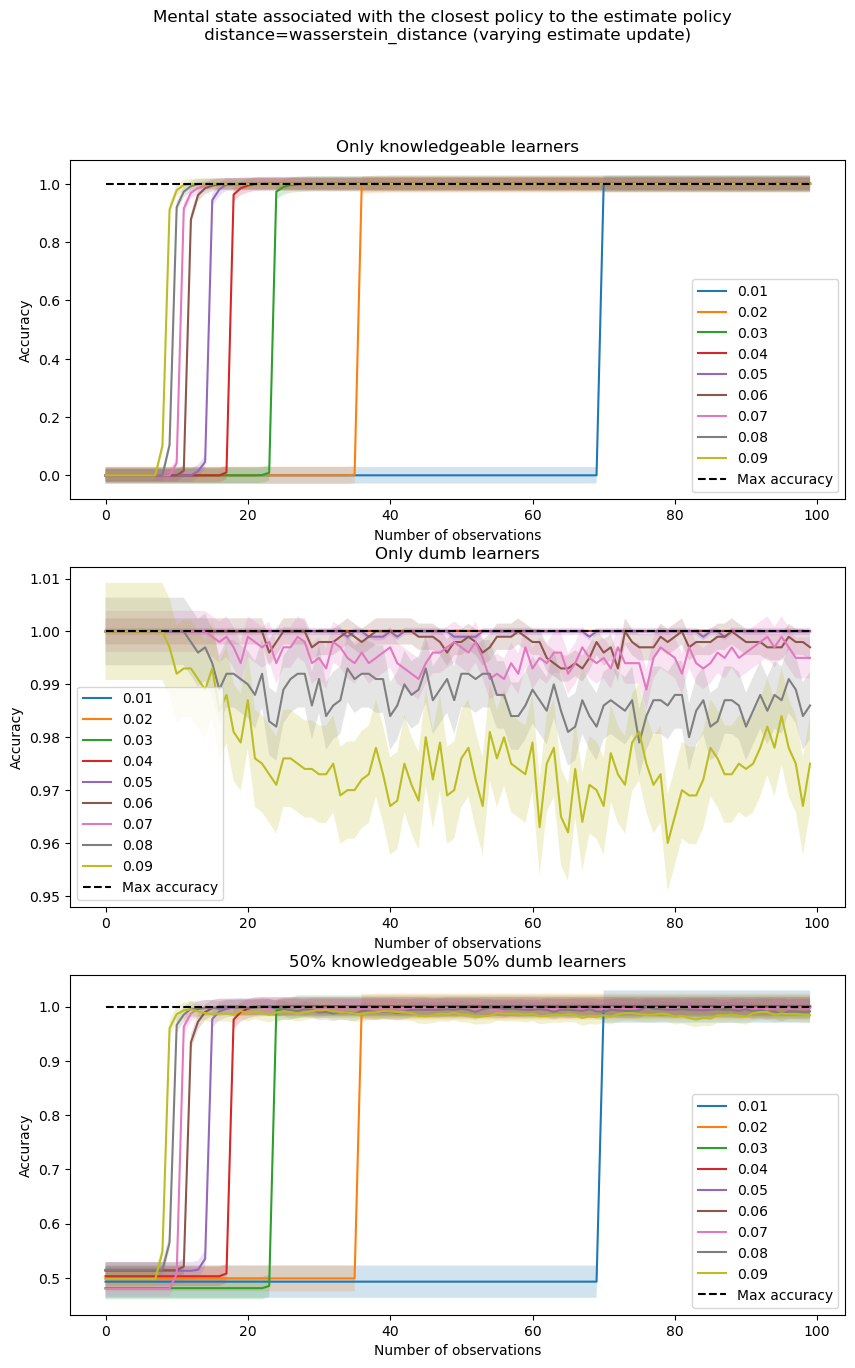

In [77]:
display_accuracy(dictionnaries, sub_titles, d_mass_values, title, num_obs, N)

##### Experiments - hard threshold on the distance to a referent policy

In [ ]:
# Predict dumb learner until the distance to the knowledgeable policy is smaller than eps

d_mass_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]
N = 1000
num_obs = 100
referent = 'knowledgeable'
distance = wasserstein_distance
eps = 0.02
title = f"Dumb learner until the distance to the knowledgeable policy is smaller than eps \n \
        distance={distance.__name__} eps={eps} (varying estimate update)"

dictionnaries, sub_titles = [], []
dictionnaries.append(test_accuracy(d_mass_values, 'threshold', num_obs=num_obs, N=N, referent=referent, 
                                   eps=eps, learner_type='knowledgeable'))
sub_titles.append('Only knowledgeable learners')
dictionnaries.append(test_accuracy(d_mass_values, 'threshold', num_obs=num_obs, N=N, referent=referent, 
                                   eps=eps, learner_type='dumb'))
sub_titles.append('Only dumb learners')
dictionnaries.append(test_accuracy(d_mass_values, 'threshold', num_obs=num_obs, N=N, referent=referent, 
                                   eps=eps, learner_type=None))
sub_titles.append("50% knowledgeable 50% dumb learners")

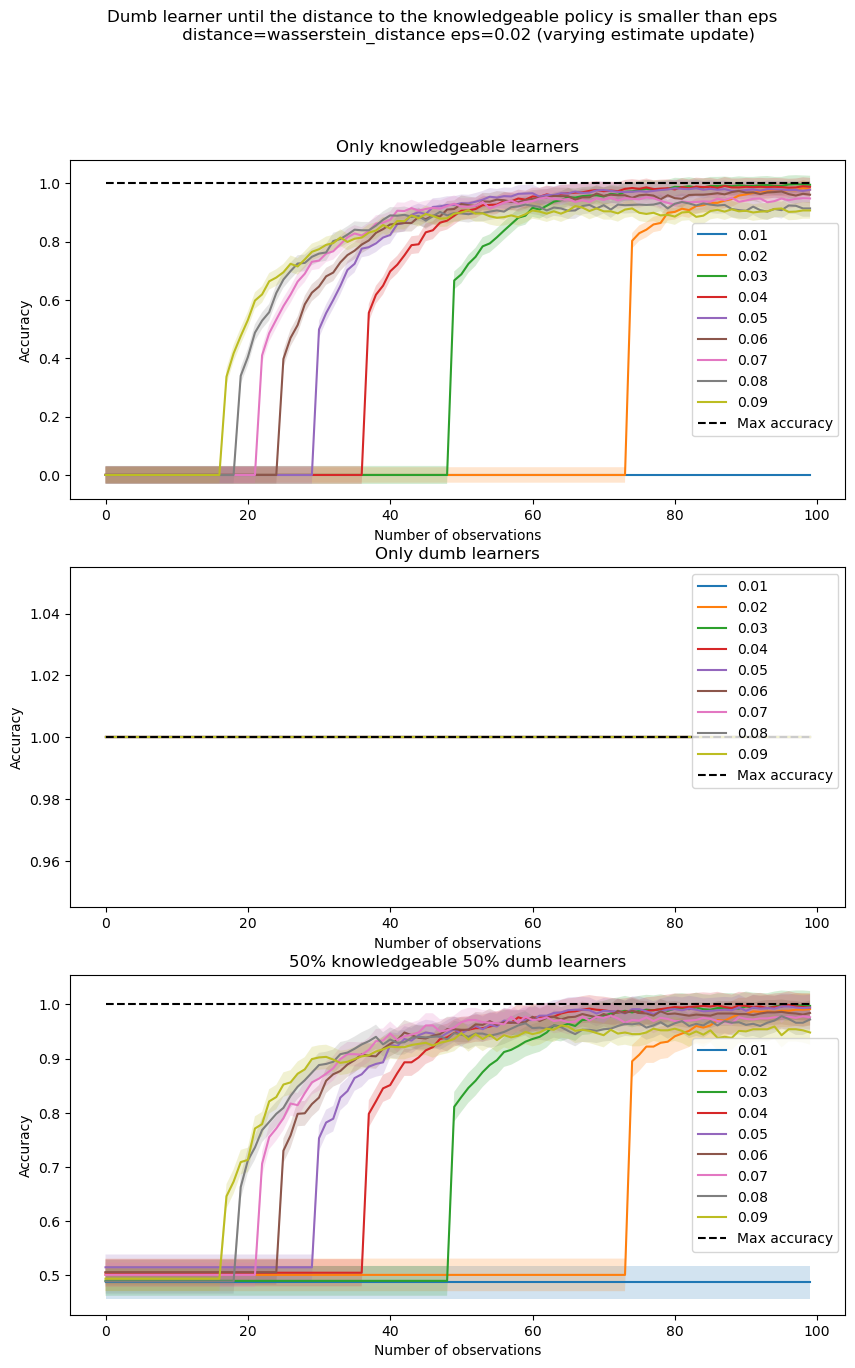

In [93]:
display_accuracy(dictionnaries, sub_titles, d_mass_values, title, num_obs, N)

In [ ]:
# Predict knowledgeable learner until the distance to the dumb policy is smaller than eps

d_mass_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]
N = 1000
num_obs = 100
referent = 'dumb'
distance = wasserstein_distance
eps = 0.04
title = f"Knowledgeable learner until the distance to the dumb policy is smaller than eps \n \
        distance={distance.__name__} eps={eps} (varying estimate update)"

dictionnaries, sub_titles = [], []
dictionnaries.append(test_accuracy(d_mass_values, 'threshold', num_obs=num_obs, N=N, referent=referent, 
                                   eps=eps, learner_type='knowledgeable'))
sub_titles.append('Only knowledgeable learners')
dictionnaries.append(test_accuracy(d_mass_values, 'threshold', num_obs=num_obs, N=N, referent=referent, 
                                   eps=eps, learner_type='dumb'))
sub_titles.append('Only dumb learners')
dictionnaries.append(test_accuracy(d_mass_values, 'threshold', num_obs=num_obs, N=N, referent=referent, 
                                   eps=eps, learner_type=None))
sub_titles.append("50% knowledgeable 50% dumb learners")

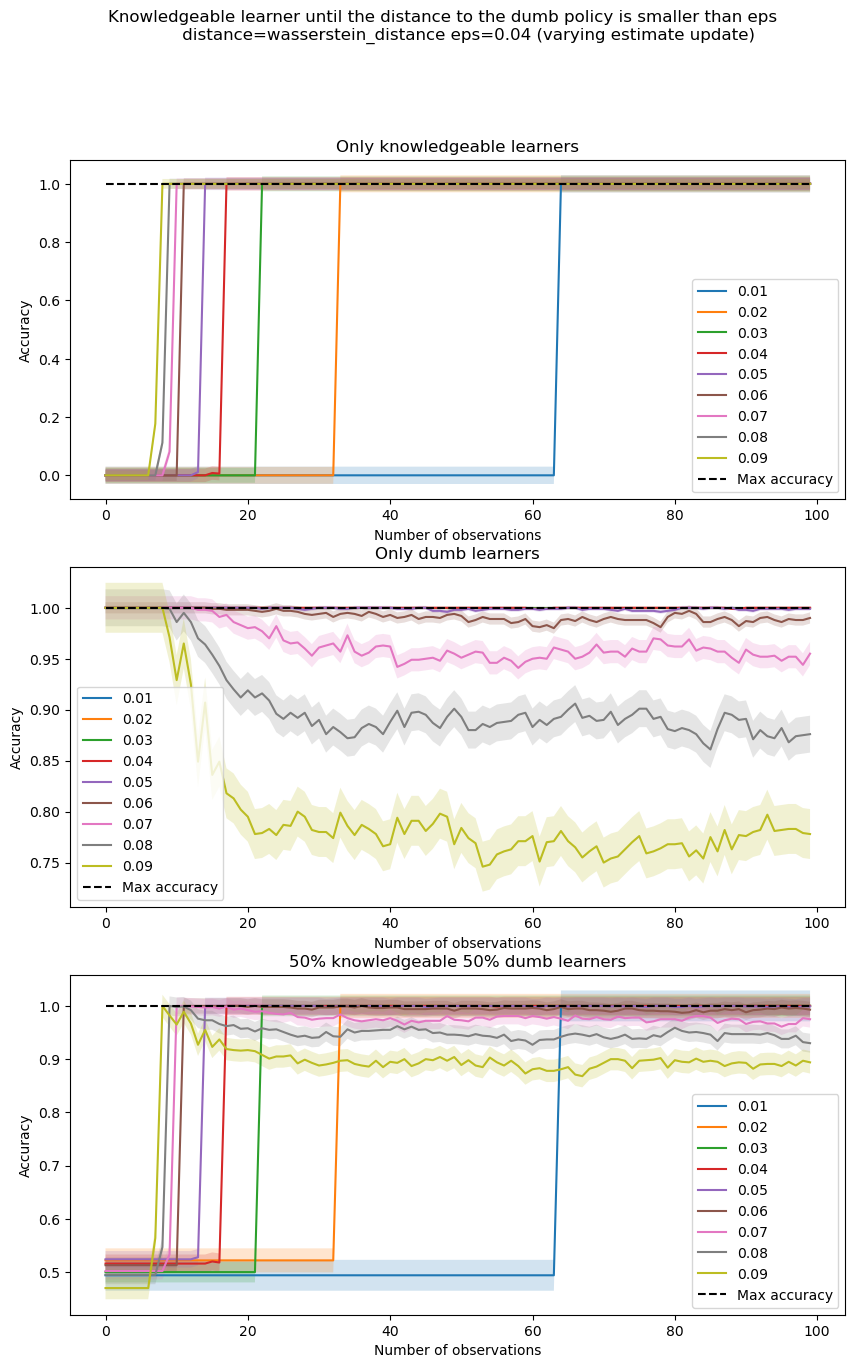

In [95]:
display_accuracy(dictionnaries, sub_titles, d_mass_values, title, num_obs, N)

##### Experiments - utility maximization

In [ ]:
# Predict mental state whose demonstration maximizes the utility

d_mass_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]
N = 1000
num_obs = 100
alpha = 0.02
cost_funct = lambda x : cost(x, alpha=alpha)
title = f"Mental state whose demonstration maximizes the utility \n alpha={alpha} (varying estimate update)"

dictionnaries, sub_titles = [], []
dictionnaries.append(test_accuracy(d_mass_values, 'utility', num_obs=num_obs, N=N, cost_funct=cost_funct, learner_type='knowledgeable'))
sub_titles.append('Only knowledgeable learners')
dictionnaries.append(test_accuracy(d_mass_values, 'utility', num_obs=num_obs, N=N, cost_funct=cost_funct, learner_type='dumb'))
sub_titles.append('Only dumb learners')
dictionnaries.append(test_accuracy(d_mass_values, 'utility', num_obs=num_obs, N=N, cost_funct=cost_funct, learner_type=None))
sub_titles.append("50% knowledgeable 50% dumb learners")

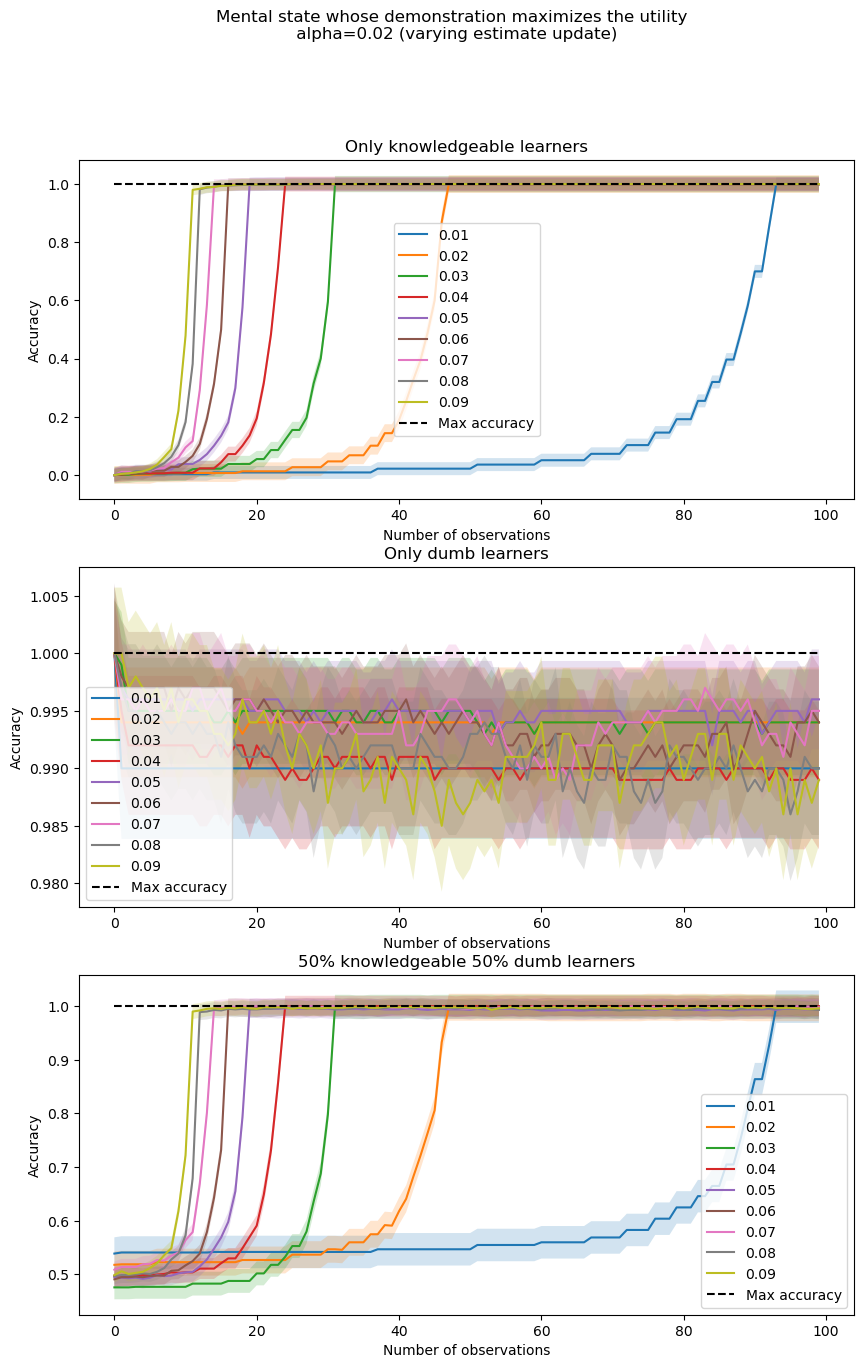

In [97]:
display_accuracy(dictionnaries, sub_titles, d_mass_values, title, num_obs, N)

In [ ]:
d_mass_values = [0.05]
alpha_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.09]
N = 1000
num_obs = 100
dictionnaries, sub_titles = [], []
title = f'Mental state whose demonstration maximizes the utility \n d_mass={d_mass_values[0]} (varying cost function parameter)'

# Only knowledgeable learners
dictionnaries.append([test_accuracy(d_mass_values, 'utility', num_obs=num_obs, N=N, cost_funct=lambda x : cost(x, alpha=alpha), learner_type='knowledgeable') for alpha in alpha_values])
sub_titles.append('Only knowledgeabe learners')
# Only dumb learner
dictionnaries.append([test_accuracy(d_mass_values, 'utility', num_obs=num_obs, N=N, cost_funct=lambda x : cost(x, alpha=alpha), learner_type='dumb') for alpha in alpha_values])
sub_titles.append('Only dumb learners')
# 50% knowledgeable learners 50% dumb learners
dictionnaries.append([test_accuracy(d_mass_values, 'utility', num_obs=num_obs, N=N, cost_funct=lambda x : cost(x, alpha=alpha), learner_type=None) for alpha in alpha_values])
sub_titles.append('50% knowledgeable learners 50% dumb learners')

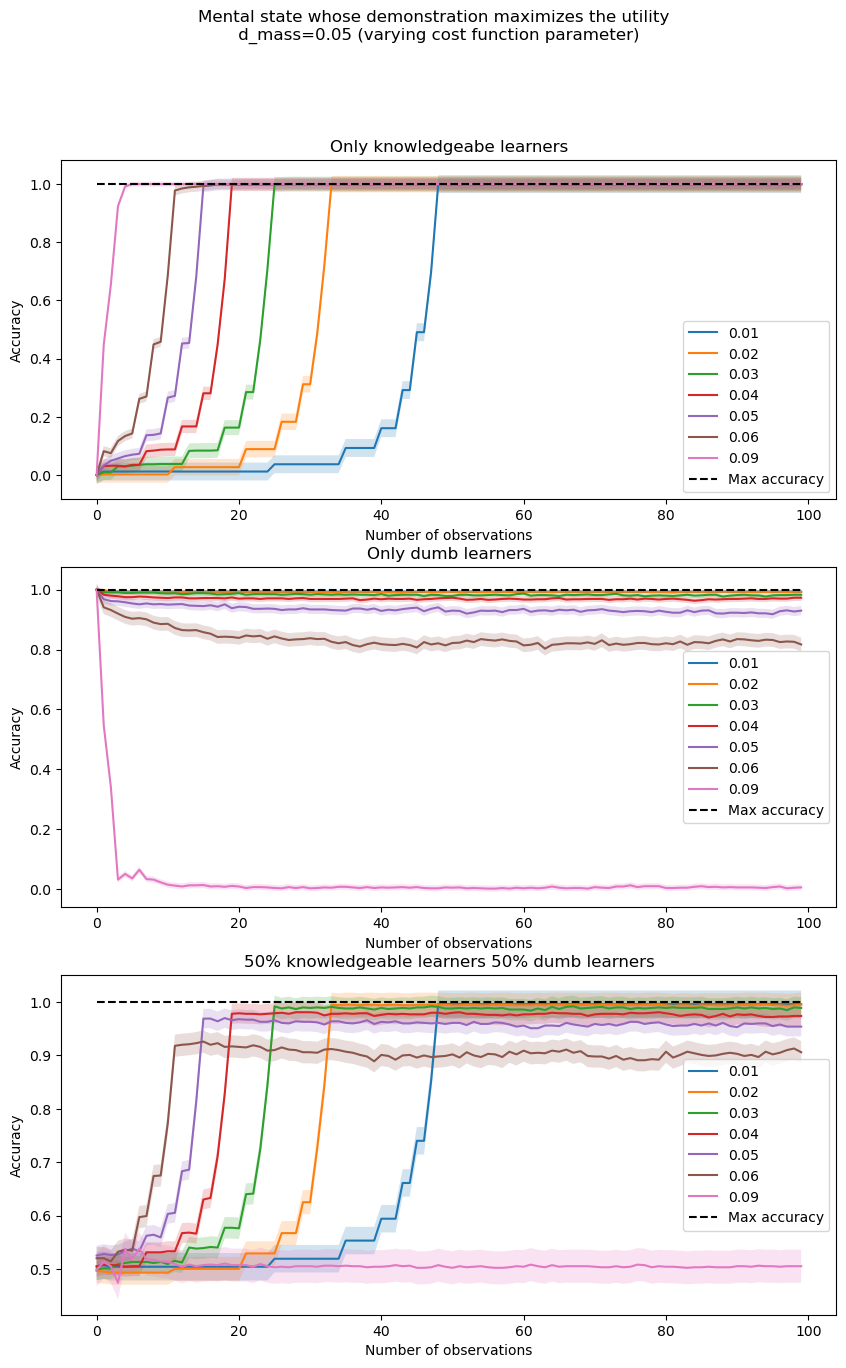

In [85]:
fig, axes = plt.subplots(len(dictionnaries), 1, figsize=(10,15))
for ii,l in enumerate(dictionnaries):
    ax = axes[ii]
    for jj,dict in enumerate(l):
        all_evals = np.array(dict[d_mass_values[0]]['all_evals'])
        mean = np.mean(all_evals, axis=0)
        std = np.std(all_evals)

        ax.plot(mean, label=str(alpha_values[jj]))
        ax.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N), mean - 1.96 * std/np.sqrt(N), alpha=0.2)

    ax.plot(np.arange(num_obs), [1] * num_obs, c='k', label="Max accuracy", ls='--')
    ax.set_xlabel('Number of observations')
    ax.set_ylabel('Accuracy')
    ax.set_title(sub_titles[ii])
    ax.legend()
fig.suptitle(title);


#### Bayesian beliefs
Probability distribution on a set of possible policies for the learner (Bayesian update)

Bayesian belief update:
$$ b_{t+1}(\pi) \propto \pi(a)\times b_t(\pi)$$

In [48]:
class ToMTeacher(Teacher):
    # Learner representation
    beliefs = None
    possible_policies = []
    demonstrations = []
    learning_env = None
    env = None

    def __init__(self, learning_env, env):
        super().__init__(env)
        self.learning_env = learning_env
        self.env = env
        self.possible_policies = []
        self.demonstrations = []
        
        # Uniform policy
        self.possible_policies.append(np.ones_like(self.learning_env.R) / self.learning_env.R.shape[0])
        actions, rewards = [], []
        for idx in range(self.env.n_buttons):
            actions.append(idx)
            rewards.append(self.env.eval(idx))
        self.demonstrations.append((actions, rewards))

        # Perfect policy
        self.possible_policies.append(self.learning_env.R / self.learning_env.R.sum())
        actions, rewards = [], []
        for idx in np.where(self.env.R==1)[0]:
            actions.append(idx)
            rewards.append(self.env.eval(idx))
        self.demonstrations.append((actions, rewards))

        assert len(self.possible_policies) == len(self.demonstrations)
        # No initial prior
        self.beliefs = np.ones(len(self.possible_policies)) / len(self.possible_policies)

    def observe(self, trajectory):
        # Bayesian update of the beliefs
        actions, _ = trajectory
        for action in actions:
            for ii,pi in enumerate(self.possible_policies):
                self.beliefs[ii] *= pi[action] # WRANING: sensible ++ to noise
        self.beliefs /= self.beliefs.sum()
        
    def demonstrate(self):
        # Take the demonstration associeted with the most probable hidden 
        # learner policy (i.e. mental state)
        argmax_set = np.where(np.isclose(self.beliefs, np.max(self.beliefs)))[0]
        most_probable_policy = np.random.choice(argmax_set)
        if most_probable_policy == 0:
            is_knowledgeable = False
        else:
            is_knowledgeable = True
        return self.demonstrations[most_probable_policy][0], self.demonstrations[most_probable_policy][1], is_knowledgeable

In [49]:
n = 20
m = 3

learning_env = ButtonsToy(n, m, music_idx=[0,1,2])
evaluation_env = ButtonsToy(n, m)

##### Evolution of the beliefs

In [50]:
tom_teacher = ToMTeacher(learning_env, evaluation_env)
learner = Learner(learning_env, knowledgeable=True)

In [56]:
# Knowledgeable learner
tom_teacher = ToMTeacher(learning_env, evaluation_env)
learner = Learner(learning_env, knowledgeable=True)

beliefs_know = []
beliefs_dumb = []
num_obs = 5

for _ in range(num_obs):
  beliefs_know.append(tom_teacher.beliefs.copy())
  traj = learner.act()
  tom_teacher.observe(traj)

# Dumb learner
tom_teacher = ToMTeacher(learning_env, evaluation_env)
learner = Learner(learning_env, knowledgeable=False)
for _ in range(num_obs):
  beliefs_dumb.append(tom_teacher.beliefs.copy())
  traj = learner.act()
  tom_teacher.observe(traj)

beliefs_all = [beliefs_know, beliefs_dumb]
sub_titles = ['Knowledgeable learner', 'Dumb learner']

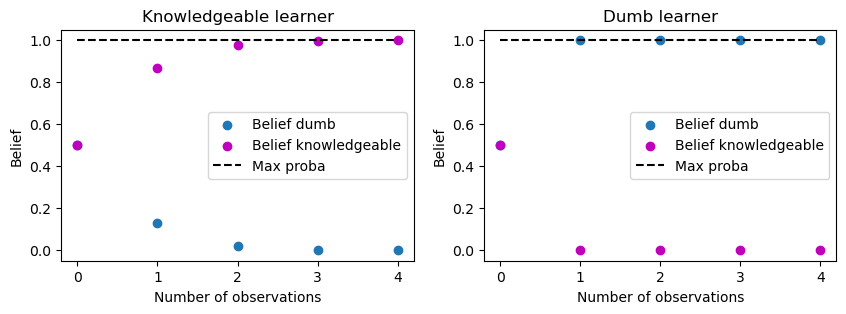

In [58]:
fig = plt.figure(figsize=(10,3))

for ii,beliefs in enumerate(beliefs_all):
    beliefs = np.array(beliefs)
    fig.add_subplot(1,2,ii + 1)
    plt.scatter(np.arange(num_obs), beliefs[:,0], label='Belief dumb')
    plt.scatter(np.arange(num_obs), beliefs[:,1], label='Belief knowledgeable', c='m')
    plt.title(sub_titles[ii])
    plt.xlabel('Number of observations')
    plt.ylabel('Belief')
    plt.plot(np.arange(num_obs), [1] * num_obs, c='k', label="Max proba", ls='--')
    plt.legend();

##### Experiment utils

In [53]:
def test_accuracy_bayesian(N=1000, num_obs=10, learner_type=None):
    dict = {}
    all_evals = []
    for _ in trange(N):
        # Generate new env 
        learning_env = ButtonsToy(n, m)
        env = ButtonsToy(n, m)
        tom_teacher = ToMTeacher(learning_env, env)
        if learner_type == None:
            learner = Learner(learning_env, knowledgeable=(np.random.rand() < 0.5))
        elif learner_type == 'knowledgeable':
            learner = Learner(learning_env, knowledgeable=True)
        elif learner_type == 'dumb':
            learner = Learner(learning_env, knowledgeable=False)
        else:
            raise ValueError('Unknown learner type')
        evals = []
        for _ in range(num_obs):
            # Teacher evaluation
            _, _, is_knowledgeable = tom_teacher.demonstrate()
            evals.append(is_knowledgeable == learner.is_knowledgeable)
            # Learner plays and teacher observes
            traj = learner.act()
            tom_teacher.observe(traj)
        all_evals.append(evals)
    dict['all_evals'] = all_evals
    return dict

In [54]:
N = 1000
n = 10
dictionnaries, sub_titles = [], []

dictionnaries.append(test_accuracy_bayesian(N, num_obs, learner_type='knowledgeable'))
sub_titles.append('Only knowledgeable learners')
dictionnaries.append(test_accuracy_bayesian(N, num_obs, learner_type='dumb'))
sub_titles.append('Only dumb learners')
dictionnaries.append(test_accuracy_bayesian(N, num_obs, learner_type=None))
sub_titles.append("50% knowledgeable 50% dumb learners")

100%|██████████| 1000/1000 [00:00<00:00, 6490.06it/s]


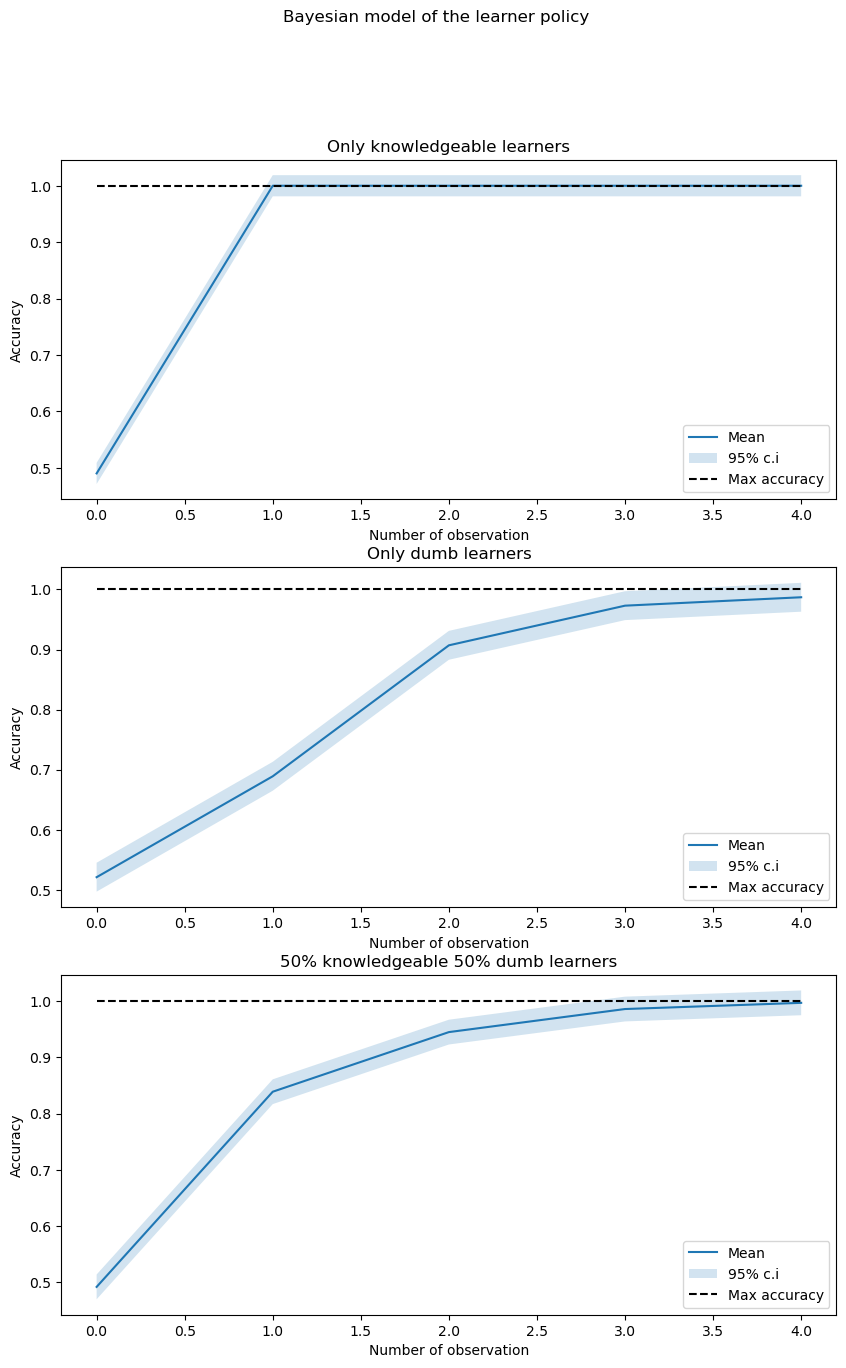

In [55]:
fig, axes = plt.subplots(len(dictionnaries), 1, figsize=(10,15))
for ii,dict in enumerate(dictionnaries):
    ax = axes[ii]
    all_evals = np.array(dict['all_evals'])
    mean = np.mean(all_evals, axis=0)
    std = np.std(all_evals)

    ax.plot(mean, label='Mean')
    ax.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N), mean - 1.96 * std/np.sqrt(N), \
                    alpha=0.2, label='95% c.i')
    ax.plot(np.arange(num_obs), [1] * num_obs, c='k', label="Max accuracy", ls='--')
    ax.set_title(sub_titles[ii])
    ax.set_xlabel('Number of observation')
    ax.set_ylabel('Accuracy')
    ax.legend()
fig.suptitle('Bayesian model of the learner policy');

### Phase 2 - Learner use its prior knowledge on the toy 1 and the teacher demonstration on toy 2 to solve toy 2